In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Load the datasets
mouse_metadata = pd.read_csv('Mouse_metadata.csv')
study_results = pd.read_csv('Study_results.csv')

# Merge the DataFrames
merged_data = pd.merge(mouse_metadata, study_results, on='Mouse ID')

# Display number of unique mice IDs
unique_mice = merged_data['Mouse ID'].nunique()
print(f"Number of unique mice IDs: {unique_mice}")

# Check for any mouse ID with duplicate time points
duplicate_mice = merged_data[merged_data.duplicated(subset=['Mouse ID', 'Timepoint'], keep=False)]
print(f"Duplicate entries: {duplicate_mice}")

# Remove the duplicate mouse data
cleaned_data = merged_data.drop_duplicates(subset=['Mouse ID', 'Timepoint'])

# Display the updated number of unique mice IDs
updated_unique_mice = cleaned_data['Mouse ID'].nunique()
print(f"Updated number of unique mice IDs: {updated_unique_mice}")


Number of unique mice IDs: 249
Duplicate entries:     Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
908     g989     Propriva  Female          21          26          0   
909     g989     Propriva  Female          21          26          0   
910     g989     Propriva  Female          21          26          5   
911     g989     Propriva  Female          21          26          5   
912     g989     Propriva  Female          21          26         10   
913     g989     Propriva  Female          21          26         10   
914     g989     Propriva  Female          21          26         15   
915     g989     Propriva  Female          21          26         15   
916     g989     Propriva  Female          21          26         20   
917     g989     Propriva  Female          21          26         20   

     Tumor Volume (mm3)  Metastatic Sites  
908           45.000000                 0  
909           45.000000                 0  
910           48.786801  

In [13]:
# Group data by Drug Regimen
grouped_data = cleaned_data.groupby('Drug Regimen')

# Create summary statistics DataFrame
summary_stats = grouped_data['Tumor Volume (mm3)'].agg(['mean', 'median', 'var', 'std', 'sem'])
print(summary_stats)


                   mean     median        var       std       sem
Drug Regimen                                                     
Capomulin     40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin      52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol     52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril      55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol      54.331565  52.509285  66.173479  8.134708  0.596466
Placebo       54.033581  52.288934  61.168083  7.821003  0.581331
Propriva      52.393463  50.909965  43.138803  6.568014  0.525862
Ramicane      40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn      54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol     53.236507  51.818479  48.533355  6.966589  0.516398


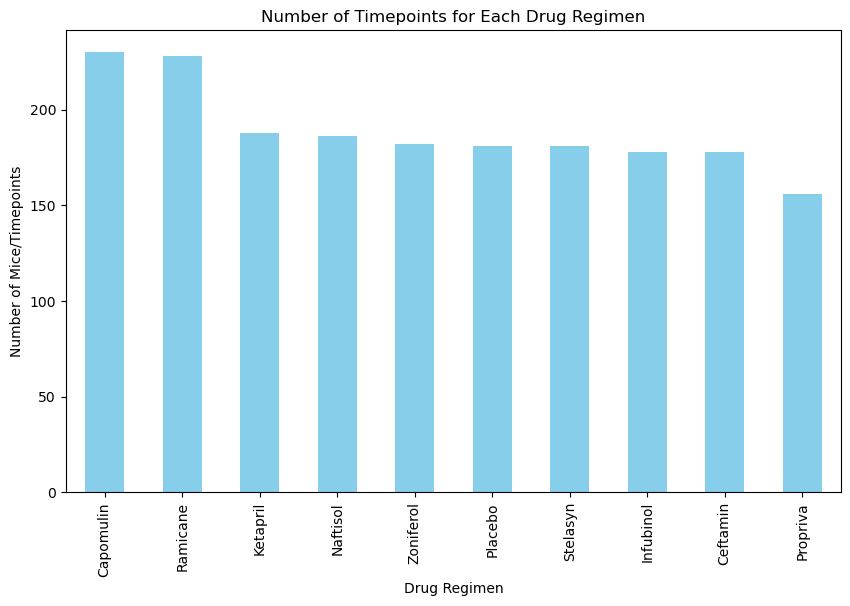

In [16]:
# Count number of rows per drug regimen
regimen_count = cleaned_data['Drug Regimen'].value_counts()

# Bar chart with Pandas
regimen_count.plot(kind='bar', color='skyblue', figsize=(10,6))
plt.title('Number of Timepoints for Each Drug Regimen')
plt.ylabel('Number of Mice/Timepoints')
plt.xlabel('Drug Regimen')
plt.show()


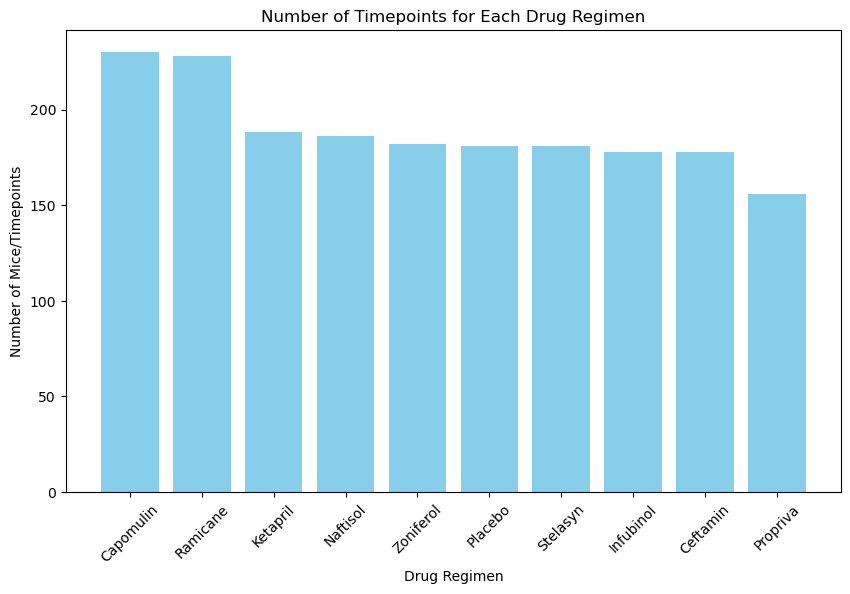

In [18]:
# Bar chart with Matplotlib
plt.figure(figsize=(10,6))
plt.bar(regimen_count.index, regimen_count.values, color='skyblue')
plt.title('Number of Timepoints for Each Drug Regimen')
plt.ylabel('Number of Mice/Timepoints')
plt.xlabel('Drug Regimen')
plt.xticks(rotation=45)
plt.show()


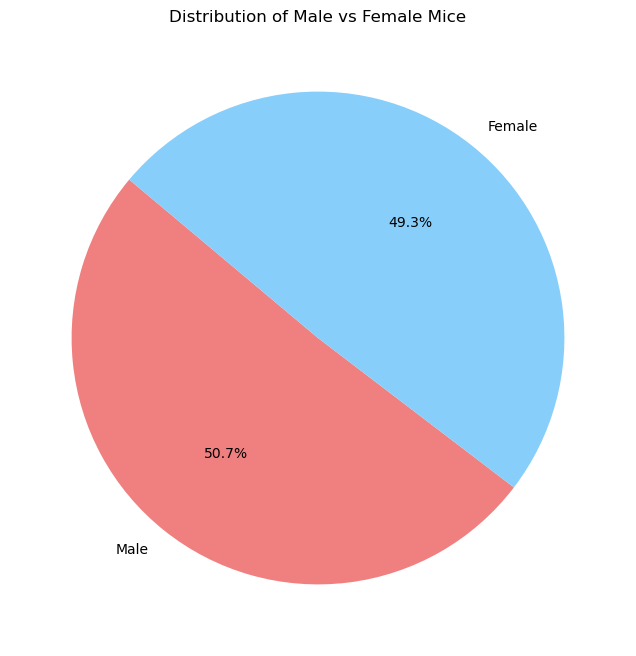

In [20]:
# Pie chart with Pandas
sex_count = cleaned_data['Sex'].value_counts()
sex_count.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8,8), colors=['lightcoral', 'lightskyblue'])
plt.title('Distribution of Male vs Female Mice')
plt.ylabel('')
plt.show()


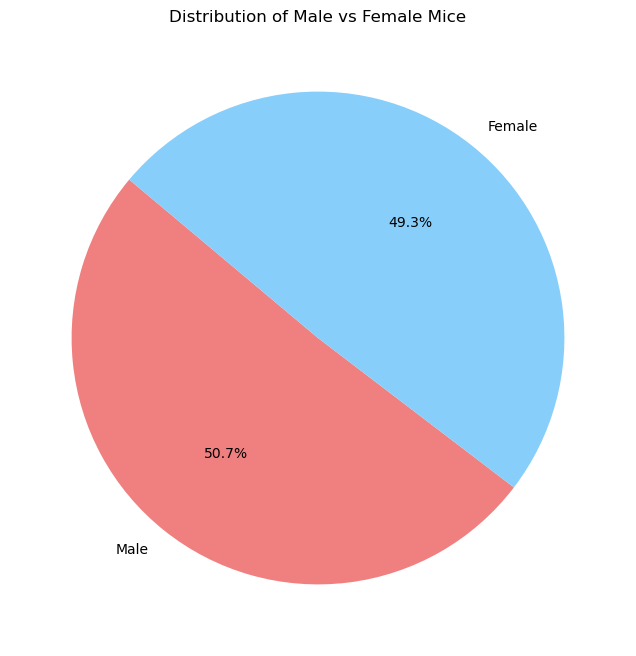

In [22]:
# Pie chart with Matplotlib
plt.figure(figsize=(8,8))
plt.pie(sex_count, labels=sex_count.index, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightskyblue'])
plt.title('Distribution of Male vs Female Mice')
plt.show()


Capomulin outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


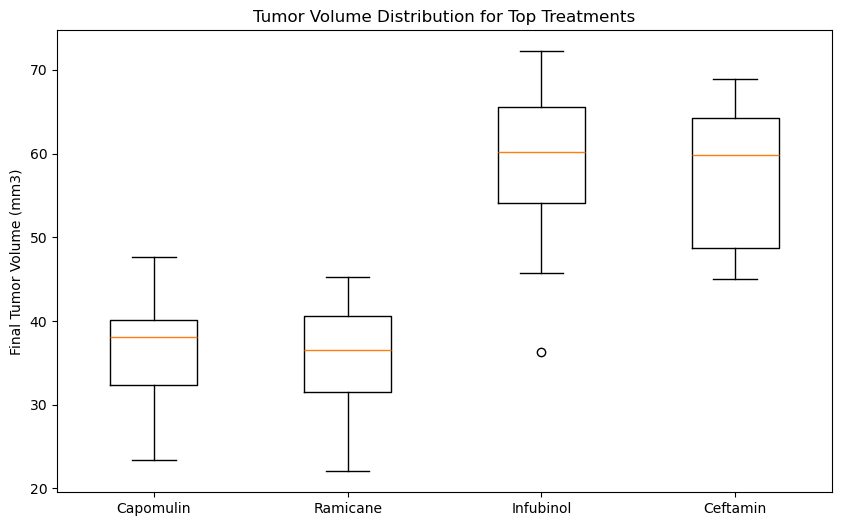

In [24]:
# Filter data for the final time point for each mouse
max_timepoint = cleaned_data.groupby('Mouse ID')['Timepoint'].max().reset_index()
final_tumor_data = pd.merge(max_timepoint, cleaned_data, on=['Mouse ID', 'Timepoint'])

# Select the promising treatment regimens
treatment_regimens = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
tumor_volumes = []

# Calculate quartiles and outliers for each treatment
for regimen in treatment_regimens:
    tumor_data = final_tumor_data.loc[final_tumor_data['Drug Regimen'] == regimen, 'Tumor Volume (mm3)']
    tumor_volumes.append(tumor_data)
    
    quartiles = tumor_data.quantile([0.25, 0.5, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    lower_bound = quartiles[0.25] - (1.5 * iqr)
    upper_bound = quartiles[0.75] + (1.5 * iqr)
    
    outliers = tumor_data[(tumor_data < lower_bound) | (tumor_data > upper_bound)]
    print(f'{regimen} outliers: {outliers}')

# Create a box plot for the selected treatment regimens
plt.figure(figsize=(10,6))
plt.boxplot(tumor_volumes, labels=treatment_regimens)
plt.title('Tumor Volume Distribution for Top Treatments')
plt.ylabel('Final Tumor Volume (mm3)')
plt.show()


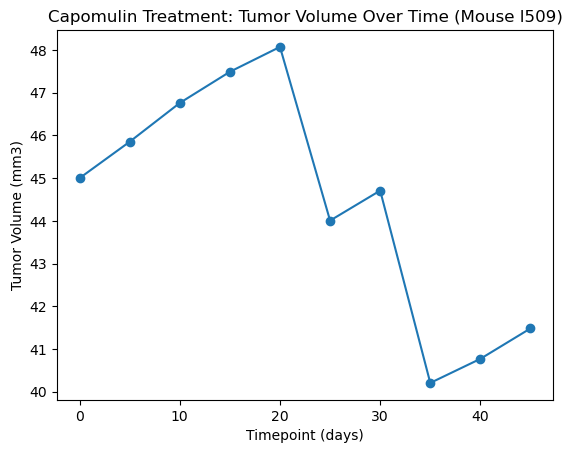

In [26]:
# Select a specific mouse treated with Capomulin
capomulin_mouse = cleaned_data[(cleaned_data['Mouse ID'] == 'l509') & (cleaned_data['Drug Regimen'] == 'Capomulin')]

# Generate line plot
plt.plot(capomulin_mouse['Timepoint'], capomulin_mouse['Tumor Volume (mm3)'], marker='o')
plt.title('Capomulin Treatment: Tumor Volume Over Time (Mouse l509)')
plt.xlabel('Timepoint (days)')
plt.ylabel('Tumor Volume (mm3)')
plt.show()


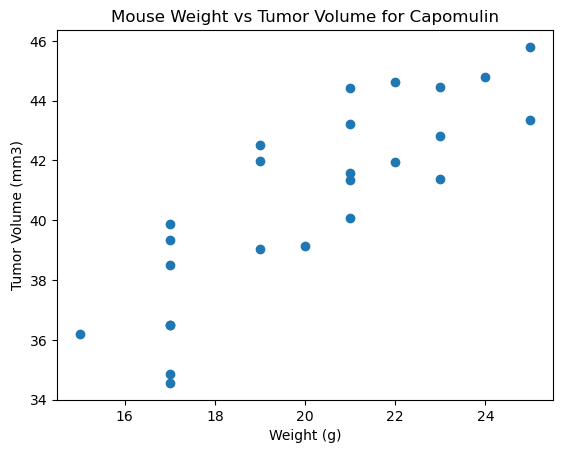

In [28]:
# Calculate average tumor volume for each mouse under Capomulin
capomulin_data = cleaned_data[cleaned_data['Drug Regimen'] == 'Capomulin']
average_tumor_volume = capomulin_data.groupby('Mouse ID')[['Weight (g)', "Tumor Volume (mm3)"]].mean()

# Generate scatter plot
plt.scatter(average_tumor_volume['Weight (g)'], average_tumor_volume['Tumor Volume (mm3)'])
plt.title('Mouse Weight vs Tumor Volume for Capomulin')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.show()

Correlation between mouse weight and tumor volume: 0.8419363424694722


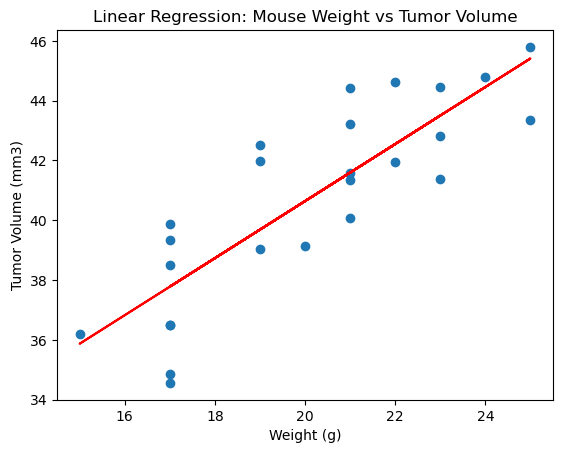

In [30]:
# Calculate correlation coefficient
correlation = average_tumor_volume['Weight (g)'].corr(average_tumor_volume['Tumor Volume (mm3)'])
print(f'Correlation between mouse weight and tumor volume: {correlation}')

# Perform linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(average_tumor_volume['Weight (g)'], average_tumor_volume['Tumor Volume (mm3)'])

# Generate regression line plot
plt.scatter(average_tumor_volume['Weight (g)'], average_tumor_volume['Tumor Volume (mm3)'])
plt.plot(average_tumor_volume['Weight (g)'], slope * average_tumor_volume['Weight (g)'] + intercept, color='red')
plt.title('Linear Regression: Mouse Weight vs Tumor Volume')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.show()
